# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [3]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

If you have access to a GPU, uncomment the following two lines. 

In [4]:
from desc import set_device
set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [5]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from desc.io import load
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.continuation import solve_continuation_automatic
from desc.optimize import Optimizer
from desc.grid import LinearGrid
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    FixCurrent,
    FixSectionLambda,
    FixSectionR,
    FixSectionZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixPsi,
    FixIota,
    QuasisymmetryTwoTerm,
    AspectRatio,
    Elongation,
    Volume,
    get_fixed_xsection_constraints,
    get_fixed_boundary_constraints,
)
from desc.examples import get
from desc.plotting import *
from desc.geometry import ZernikeRZToroidalSection, FourierRZToroidalSurface
from desc.backend import print_backend_info

print_backend_info()

DESC version=0.16.0+411.g6e1e51890.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 8.24 GB available memory.


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS for not highly shaped plasma, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

**Note:** We should emphasize that this method is shown to work for plasma with **minor** shaping. We see that optimization gets harder for highly shaped plasma (cross-sections differ substantially around toroidal direction, like `precise_QA` or `W7-X`). Further in the notebook, we will see that one reason of this is our initial guess being axisymmetric, when we warm start using the existing shaped plasma, optimization can converge to similar flux surfaces.

In [7]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [11]:
eq = get("HELIOTRON")

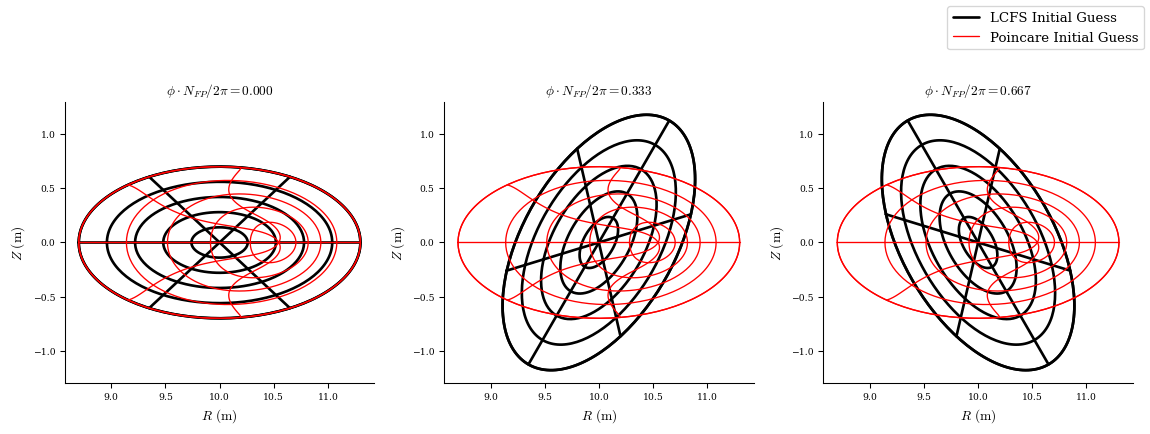

In [33]:
from desc.equilibrium.utils import parse_axis

eq_poin = set_poincare_equilibrium(eq)
eq0 = eq.copy()
eq0.axis = parse_axis(axis=None, surface=eq0.surface, NFP=eq0.NFP, sym=eq0.sym)
eq0.set_initial_guess()
plot_comparison(
    eqs=[eq0, eq_poin],
    phi=3,
    theta=6,
    rho=5,
    labels=["LCFS Initial Guess", "Poincare Initial Guess"],
    color=["k", "r"],
    lw=[2, 1],
);
plt.savefig("./PAPER_PLOTS/poincare_init_guess.png", dpi=400)

Now, we can solve the newly created `eq_poin` as usual. The code will apply some checks to see if you are trying to solve a Poincare BC problem or LCFS. Then, add the required constraints and objectives before sending it to the optimizer.

In [23]:
try:
    eq_poin = load("poincare_heliotron.h5")
except:    
    eq_poin = set_poincare_equilibrium(eq)  # zeta=0 surface will be fixed
    for N in range(1, eq.N + 1):
        print(f"\n\nSolving for N={N}...\n\n")
        eq_poin.change_resolution(N=N, N_grid=2 * N)

        constraints = get_fixed_xsection_constraints(eq=eq_poin, fix_lambda=True)
        objective = ObjectiveFunction(ForceBalance(eq_poin))

        eq_poin.solve(
            verbose=3,
            objective=objective,
            constraints=constraints,
            maxiter=75,
            ftol=1e-3,
        );

    eq_poin.surface = eq_poin.get_surface_at(rho=1)
    eq_poin.save("poincare_heliotron.h5")



Solving for N=1...


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 91.6 ms
Timer: Objective build = 102 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 113 ms
Timer: LinearConstraintProjection build = 4.56 sec
Number of parameters: 507
Number of objectives: 1900
Timer: Initializing the optimization = 4.87 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evalu

A user cannot fix both LCFS and Poincare section variables, `(Rb_lmn, Zb_lmn)` and `(Rp_lmn, Zp_lmn, Lp_lmn)` respectively. For this reason, DESC sets `(Rb_lmn, Zb_lmn)` as non-optimizable which makes the `eq.surface` attribute inconsistent with the actual surface. For now, we expect the user to set the surface manually to proper value by,

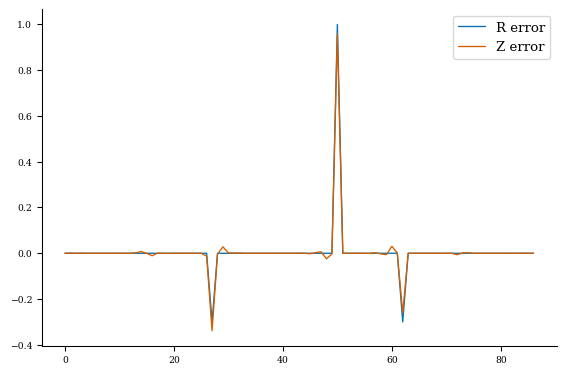

In [24]:
import matplotlib.pyplot as plt
eR = eq.Rb_lmn - eq_poin.Rb_lmn
eZ = eq.Zb_lmn - eq_poin.Zb_lmn
eL = eq.L_lmn - eq_poin.L_lmn
plt.plot(eq.Zb_lmn, label="R error")
plt.plot(eq_poin.Zb_lmn, label="Z error")
# plt.plot(eL, label="L error")
plt.legend();

Similarly, when a user don't use the Poincare variables (such that `FixSection...` or `get_fixed_xsection_constraints` is not called at all), `eq.xsection` will not be consistent with the actual $\zeta=0$ cross-section. We will probably automize this in future.

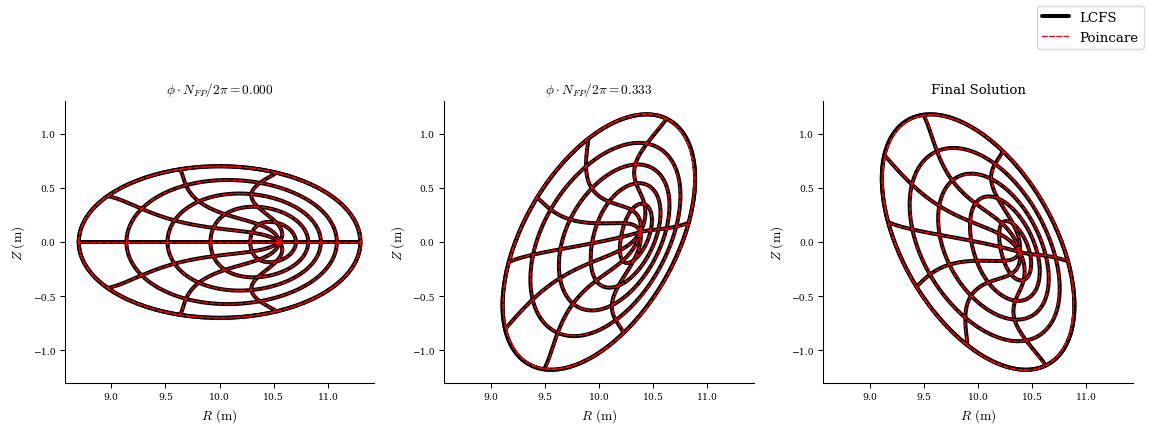

In [ ]:
plot_comparison(
    eqs=[eq, eq_poin],
    rho=5,
    phi=3,
    labels=["LCFS", "Poincare"],
    ls=["-", "--"],
    lw=[3, 1],
    color=["k", "r"],
);
plt.title("Final Solution")
plt.savefig("./PAPER_PLOTS/poincare_lcfs_final.png", dpi=400)

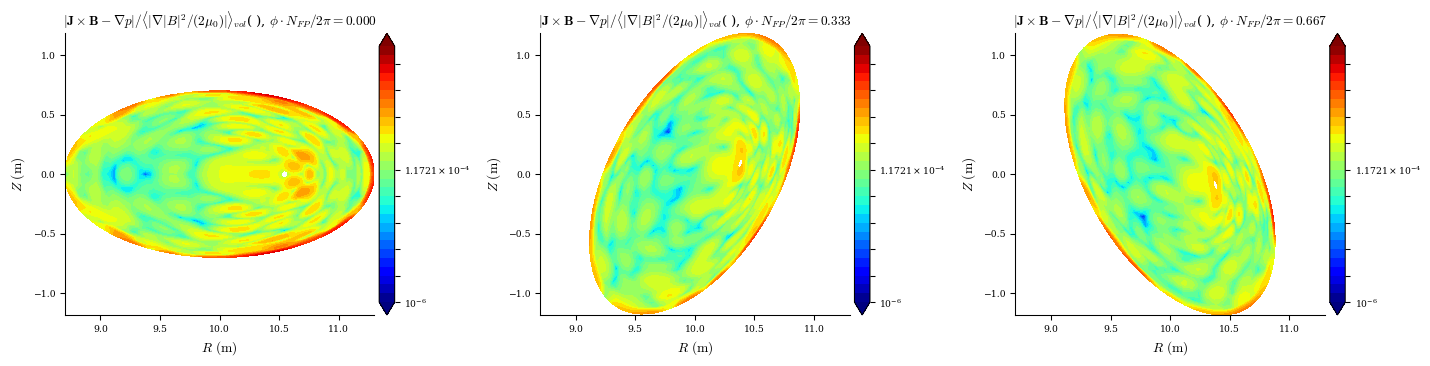

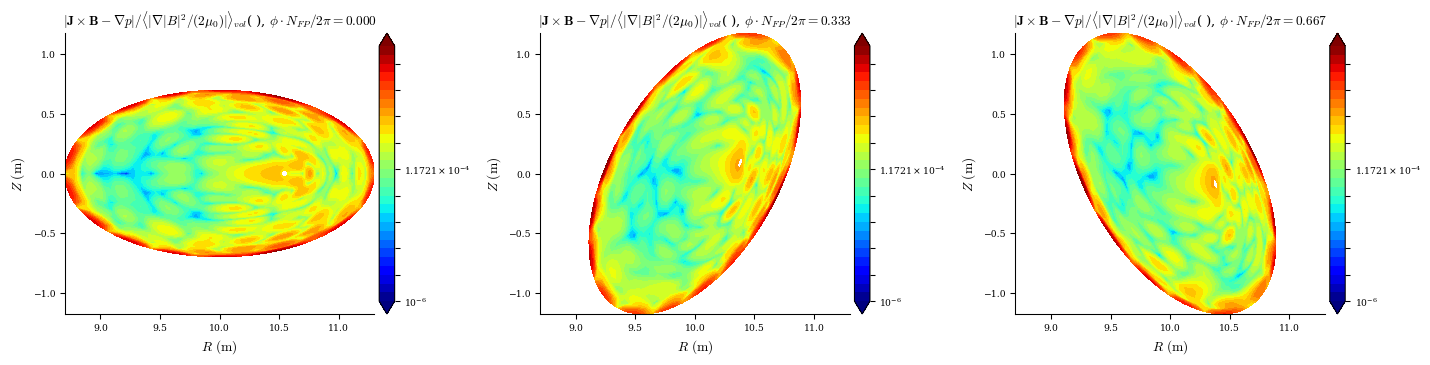

In [ ]:
levels = np.logspace(-6, -2, 30)
plot_section(eq_poin, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("./PAPER_PLOTS/force_poincare_heliotron.png", dpi=500)
plot_section(eq, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("./PAPER_PLOTS/force_lcfs_heliotron.png", dpi=500)

We can see that especially around the last closed flux surface, the final equilibrium obtained by Poincare boundary condition has lower force error. This property can be used to reduce the force balance error of an existing equilibrium. Below, it can be seen that the volume averaged normalized force error is also lower for `eq_poin`.

In [29]:
f1 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq_poin.compute("<|F|>_vol")["<|F|>_vol"]
    / eq_poin.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 3.0407e-04
Force error eq_poin: 1.8594e-04


## Using Poincare Boundary Condition to reduce Force Error around the LCFS

As we mentioned above, the equilibrium solved by Poincare boundary condition has lower force error around the LCFS. We can use this procedure to relax the last closed flux surface parameters, and obtain a better equilibrium close to the original equilibrium.

Let's use W7-X example.

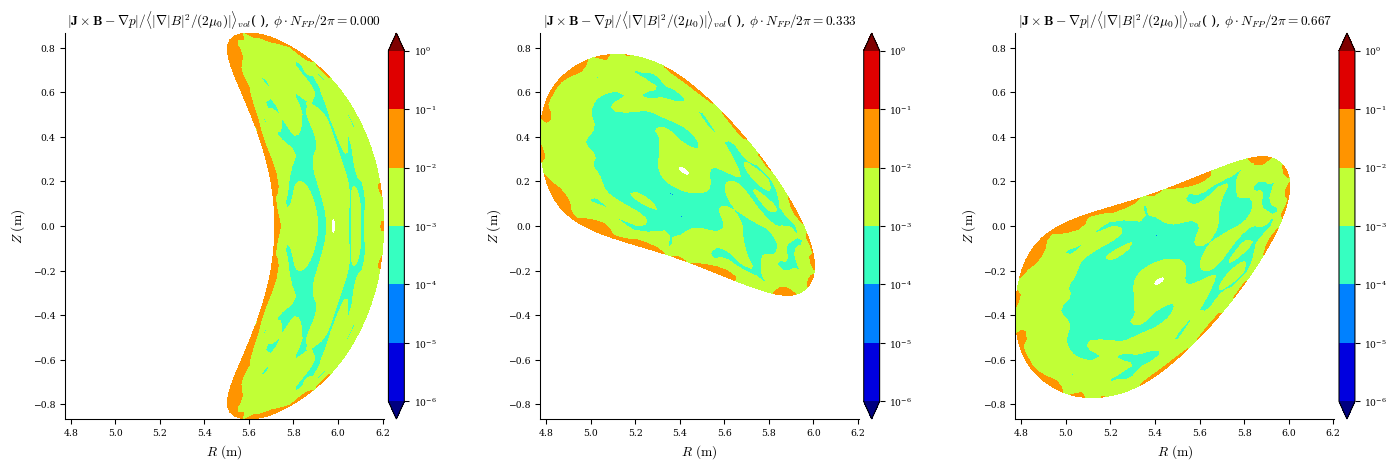

In [8]:
eq0 = get("W7-X")
plot_section(eq0, "|F|_normalized", phi=3, log=True);

This time, we will use the `get_fixed_xsection_constraints` function with `fix_lambda=False`. We can also use the default `fix_lambda=True` but by not fixing the $\lambda$, we add an additional freedom to improve the force balance at the fixed cross-section, too. We didn't use this approach above to save time, since more optimizable parameters increase the size of the Jacobian and makes every computation slower. Our initial equilibrium is already in a good force balance, therefore the new solve won't take too long, and we accept slower iterations.

In [9]:
eq = eq0.copy()
constraints = get_fixed_xsection_constraints(eq=eq, fix_lambda=False)
objective = ObjectiveFunction(ForceBalance(eq))

eq.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=50,
    ftol=1e-3,
);
eq.surface = eq.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 827 ms
Timer: Objective build = 1.44 sec
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Timer: Objective build = 606 ms
Timer: LinearConstraintProjection build = 6.01 sec
Number of parameters: 3318
Number of objectives: 5346
Timer: Initializing the optimization = 8.29 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 251
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Re

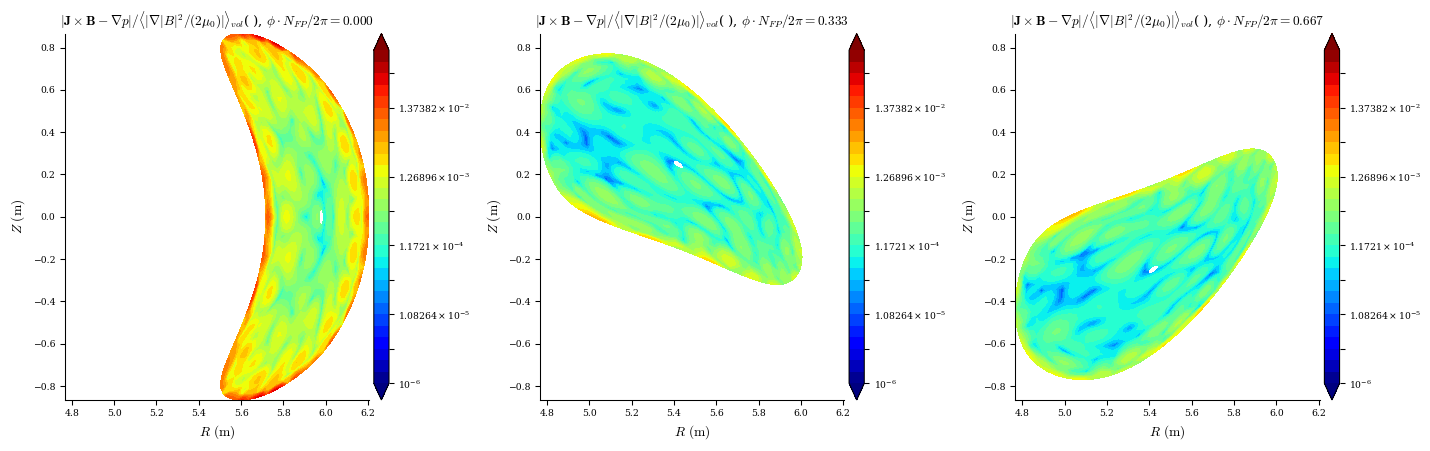

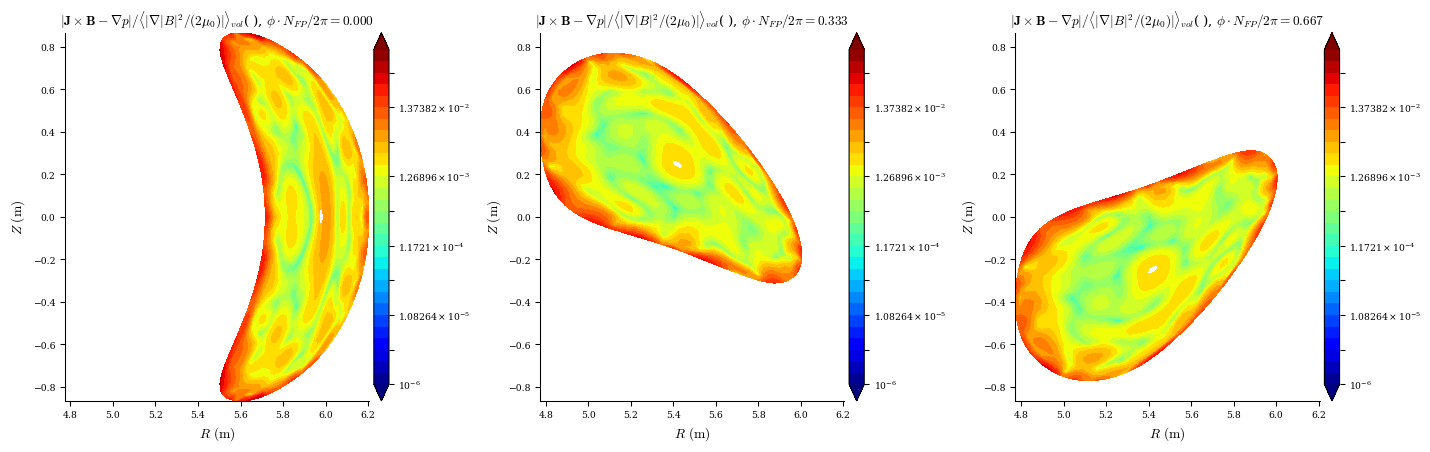

In [10]:
levels = np.logspace(-6, -1, 30)
plot_section(eq, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("./PAPER_PLOTS/force_poincare_w7x.png", dpi=500)
plot_section(eq0, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("./PAPER_PLOTS/force_lcfs_w7x.png", dpi=500)

In [11]:
f1 = (
    eq0.compute("<|F|>_vol")["<|F|>_vol"]
    / eq0.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 2.8609e-03
Force error eq_poin: 2.8528e-04


In [12]:
f1 = eq0.compute("W")["W"]
f2 = eq.compute("W")["W"]
print(f"Energy eq_lcfs: {f1:.4e}")
print(f"Energy eq_poin: {f2:.4e}")

Energy eq_lcfs: 8.4649e+07
Energy eq_poin: 8.5678e+07


As expected, we got a much better force equilibrium. And as it can be seen from the next figure, this is achieved by minor changes to the last closed flux surface shape.

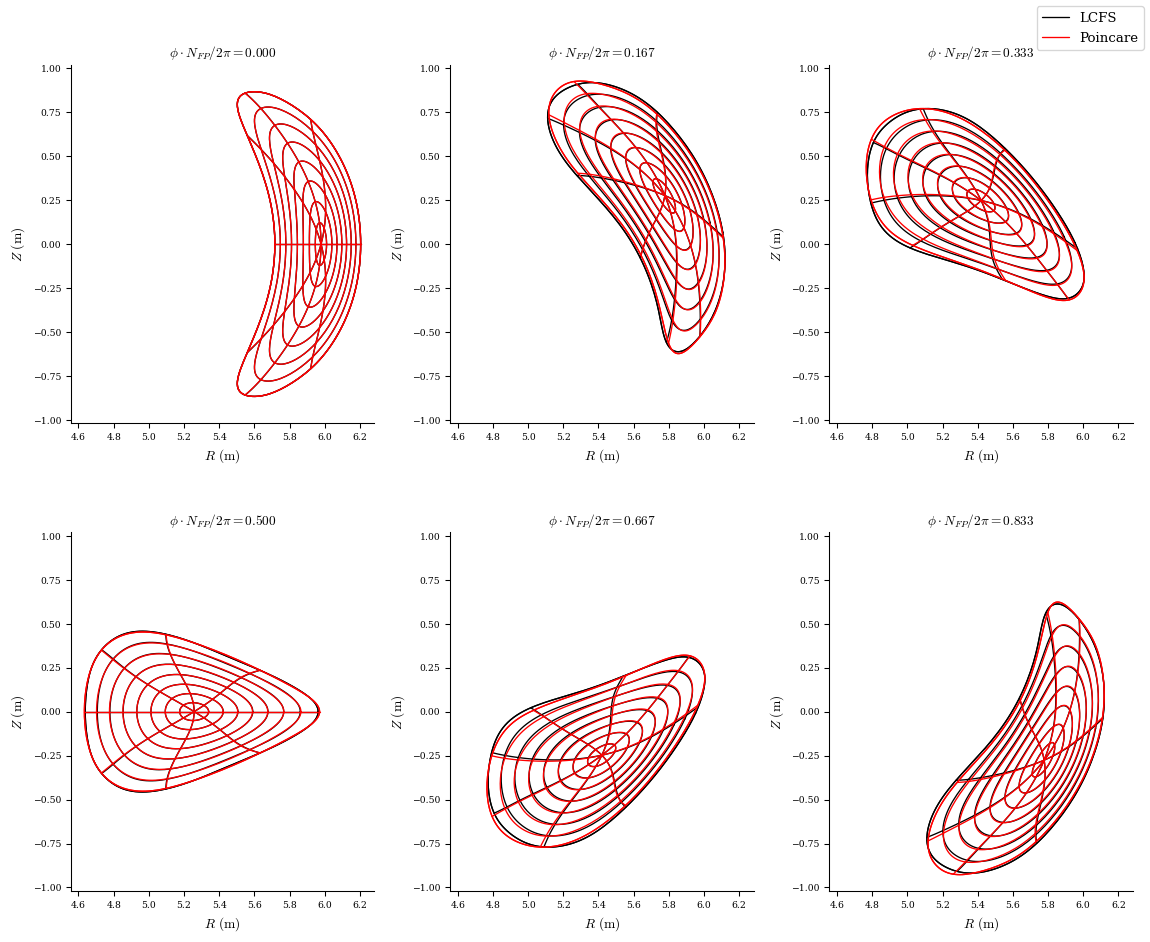

In [13]:
plot_comparison(eqs=[eq0, eq], labels=["LCFS", "Poincare"], color=["k", "r"]);

One can use the reverse strategy to improve the force balance error of the final equilibrium around the fixed cross-section, and get a much better equilibrium otherwise very hard to get (even with extermely small stopping tolerances for the optimizer).

**Important:** The analysis here only considers the force balance, however, the LCFS of `W7-X` and other example equilibria in `DESC` are optimized for certain physics proxies. The above procedure improves the force balance but changes the actual optimized metrics for the final equilibrium. One needs to incorporate this procedure to optimization itself to preserve physisc objectives.

In [14]:
eq.save("w7x-poincare-solve.h5")

In [15]:
eq2 = eq.copy()
eq2.solve(verbose=3, maxiter=50, ftol=1e-3, gtol=0, xtol=0);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 78.2 ms
Timer: Objective build = 417 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 401 ms
Timer: LinearConstraintProjection build = 6.35 sec
Number of parameters: 2784
Number of objectives: 5346
Timer: Initializing the optimization = 7.46 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 251
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method              

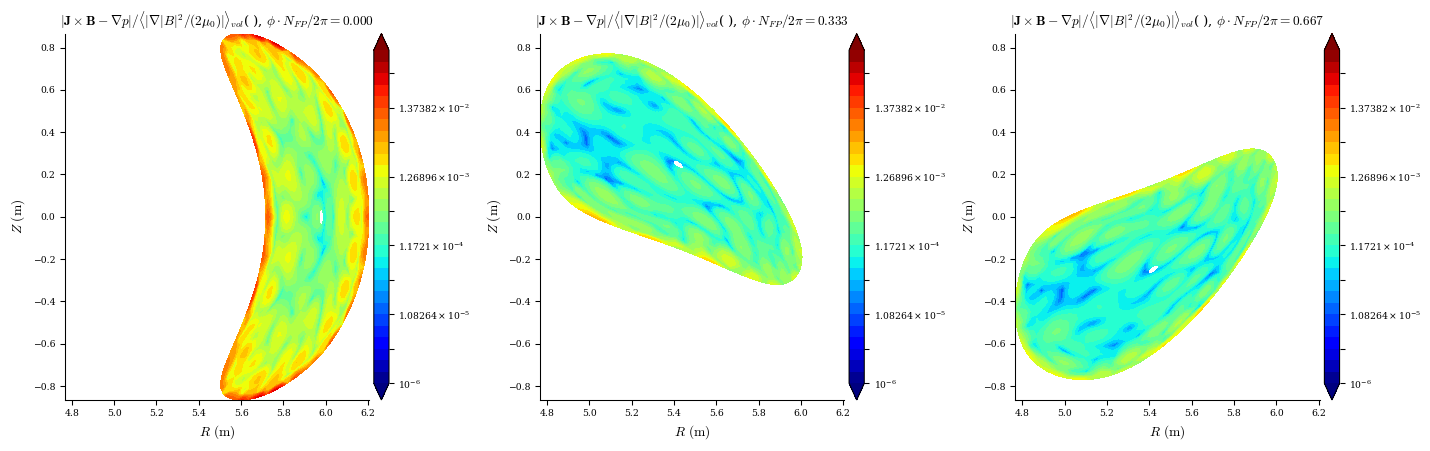

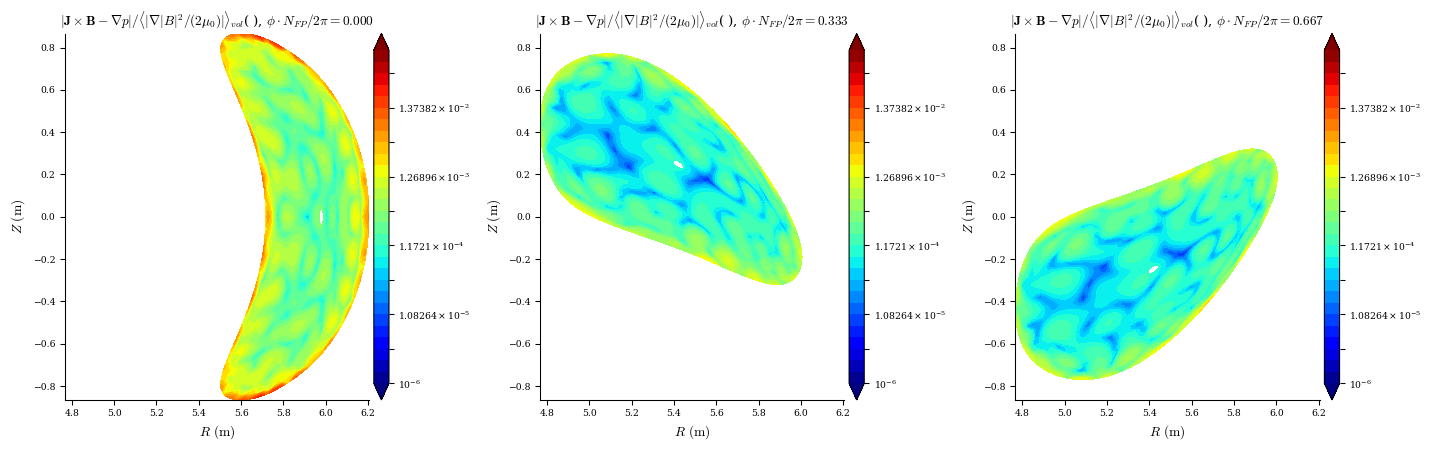

In [16]:
levels = np.logspace(-6, -1, 30)
plot_section(eq, "|F|_normalized", log=True, levels=levels, phi=3)
plot_section(eq2, "|F|_normalized", log=True, levels=levels, phi=3);
plt.savefig("./PAPER_PLOTS/force_poincare_then_lcfs_w7x.png", dpi=500)

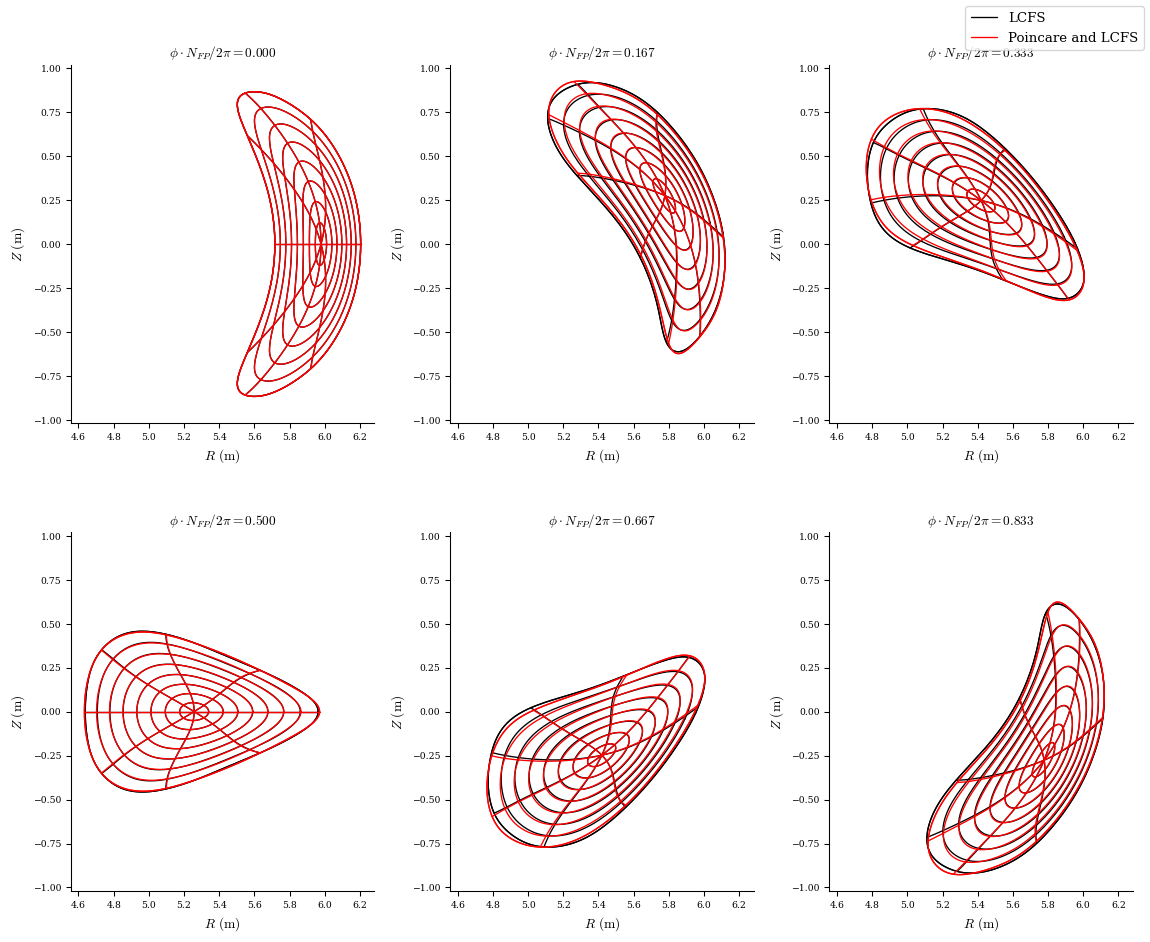

In [18]:
plot_comparison(eqs=[eq0, eq2], labels=["LCFS", "Poincare and LCFS"], color=["k", "r"]);

In [75]:
f1 = eq2.compute("W")["W"]
f2 = eq.compute("W")["W"]
print(f"Energy eq2: {f1:.4e}")
print(f"Energy eq_poin: {f2:.4e}")

Energy eq2: 8.3387e+07
Energy eq_poin: 8.3387e+07


In [19]:
f1 = (
    eq0.compute("<|F|>_vol")["<|F|>_vol"]
    / eq0.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f3 = (
    eq2.compute("<|F|>_vol")["<|F|>_vol"]
    / eq2.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error LCFS: {f1:.4e}")
print(f"Force error Poincare: {f2:.4e}")
print(f"Force error Poincare and LCFS: {f3:.4e}")

Force error LCFS: 2.8609e-03
Force error Poincare: 2.8528e-04
Force error Poincare and LCFS: 2.1846e-04
